In [0]:
try:
    %tensorflow_version 2.x
except Exception:
    pass

In [2]:
import json
import tensorflow as tf
import tensorflow.keras as keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [0]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_size = 20000

In [4]:
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json -O /tmp/sarcasm.json

--2020-05-07 06:23:33--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 2404:6800:4008:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.06s   

2020-05-07 06:23:33 (94.4 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [0]:
with open('/tmp/sarcasm.json', 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [0]:
training_sentences = sentences[:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[:training_size]
testing_labels = labels[training_size:]

In [0]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [0]:
import numpy as np

training_padded = np.array(training_padded)
testing_padded = np.array(testing_padded)
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

In [76]:
model = keras.Sequential([
                          keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
                          keras.layers.GlobalAveragePooling1D(),
                          keras.layers.Dense(25),
                          keras.layers.Activation('relu'),
                          keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.RMSprop(0.002, 0.9, 0.2), metrics=['accuracy'])
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d_14  (None, 16)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 25)                425       
_________________________________________________________________
activation_14 (Activation)   (None, 25)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 26        
Total params: 160,451
Trainable params: 160,451
Non-trainable params: 0
_________________________________________________________________


In [77]:
history = model.fit(training_padded, training_labels, epochs=30, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 3s - loss: 0.6719 - accuracy: 0.5792 - val_loss: 0.6104 - val_accuracy: 0.6368
Epoch 2/30
625/625 - 3s - loss: 0.5061 - accuracy: 0.7614 - val_loss: 0.4520 - val_accuracy: 0.7939
Epoch 3/30
625/625 - 3s - loss: 0.4111 - accuracy: 0.8152 - val_loss: 0.4041 - val_accuracy: 0.8235
Epoch 4/30
625/625 - 2s - loss: 0.3611 - accuracy: 0.8428 - val_loss: 0.3843 - val_accuracy: 0.8289
Epoch 5/30
625/625 - 3s - loss: 0.3266 - accuracy: 0.8595 - val_loss: 0.3956 - val_accuracy: 0.8186
Epoch 6/30
625/625 - 2s - loss: 0.3008 - accuracy: 0.8709 - val_loss: 0.3643 - val_accuracy: 0.8453
Epoch 7/30
625/625 - 2s - loss: 0.2808 - accuracy: 0.8822 - val_loss: 0.4094 - val_accuracy: 0.8180
Epoch 8/30
625/625 - 2s - loss: 0.2619 - accuracy: 0.8918 - val_loss: 0.3869 - val_accuracy: 0.8267
Epoch 9/30
625/625 - 2s - loss: 0.2486 - accuracy: 0.8980 - val_loss: 0.3645 - val_accuracy: 0.8483
Epoch 10/30
625/625 - 2s - loss: 0.2374 - accuracy: 0.9036 - val_loss: 0.4288 - val_accuracy: 0.8216

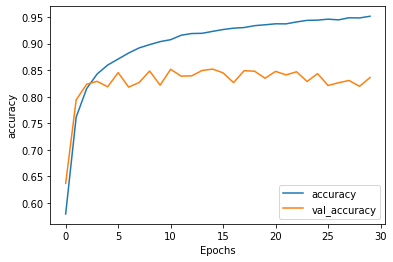

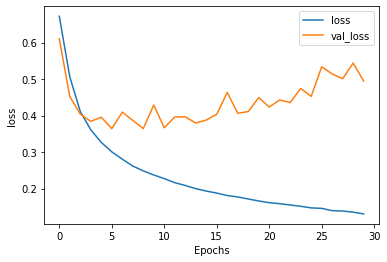

In [78]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [79]:
reverse_word_index = dict([(value,key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[2]))
print(training_sentences[50])
print(labels[50])

mom starting to fear son's web series closest thing she will have to grandchild ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
diy: sports equipment closet
0


In [80]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(10000, 16)


In [0]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1,vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + '\n')
    out_v.write('\t'.join([str(x) for x in embeddings]) + '\n')
out_v.close()
out_m.close()

In [0]:
# try:
#     from google.colab import files
# except ImportError:
#     pass
# else:
#     files.download('vecs.tsv')
#     files.download('meta.tsv')

In [83]:
sentence = ['granny starting to fear spiders in the garden might be real', 'game of thrones season finale showing this sunday night']
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[0.889261  ]
 [0.05681831]]
